# Entrega laboratorio 6
## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [600]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import random
import copy
import tabulate
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Problema 1

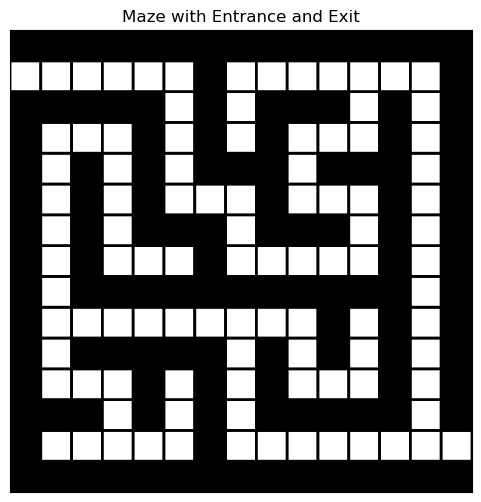

In [327]:
def load_maze(file):
    maze = np.loadtxt(file, dtype=int)
    return maze

def display_maze(maze):
    cmap = ListedColormap(['white', 'black', 'green', 'black'])
    plt.figure(figsize=(6, 6))
    plt.pcolor(maze[::-1], cmap=cmap, edgecolors='k', linewidths=2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title('Maze with Entrance and Exit')
    plt.show()

maze = load_maze('maze_case_base.txt')
display_maze(maze)

In [328]:
maze

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [599]:
def generate_population(size, genome_length):
    """
    Genera una población inicial de cromosomas (individuos).

    Args:
    size (int): El número de individuos en la población.
    genome_length (int): La longitud de cada cromosoma (número de movimientos).
    
    Returns:
    list: Una lista de listas, donde cada lista interna representa
          un cromosoma con movimientos aleatorios (0: abajo, 1: arriba,
          2: izquierda, 3: derecha).
    """
    population = []
    opposite = {
        1: 0,
        0: 1,
        2: 3,
        3: 2
    }
    for _ in range(size):
        # generates individuals without backtracking
        individual = [random.randint(0,3) for _ in range(genome_length)]
        for i in range(1, len(individual)):
            gen = individual[i]
            last_gen = individual[i-1]
            if last_gen == opposite[gen]:
                if opposite[gen] in [0, 1]:
                    individual[i] = random.randint(2,3)
                else:
                    individual[i] = random.randint(0,1)
        population.append(individual)
    return population

In [601]:
def reward(individual, maze, start, end):
    rows, cols = maze.shape
    current_row, current_col = start
    
    successful_moves = 0
    
    unique_visited_cells = set()
    unique_visited_cells.add(start)
    
    path_taken = [start]
    revisit_path_penalty_count = 0
    
    backtrack_count = 0
    
    blocked = False
    reached = False

    moves = {
        0: (1, 0),
        1: (-1, 0),
        2: (0, -1),
        3: (0, 1)
    }
    opposite_move = {
        0: 1, 
        1: 0, 
        2: 3, 
        3: 2
    }

    for i, move_gene in enumerate(individual):
        move_delta = moves.get(move_gene)

        dr, dc = move_delta
        next_row, next_col = current_row + dr, current_col + dc
        next_pos = (next_row, next_col)

        if not (0 <= next_row < rows and 0 <= next_col < cols) \
                or maze[next_row, next_col] == 1:
            blocked = True
            break
        
        if i > 0 and individual[i - 1] == opposite_move.get(move_gene):
            backtrack_count += 1
        
        if next_pos in path_taken:
            revisit_path_penalty_count += 1

        current_row, current_col = next_row, next_col
        path_taken.append(next_pos)
        unique_visited_cells.add(next_pos)
        successful_moves += 1

        if next_pos == end:
            reached = True
            break

    fitness = 0.0
    final_pos = (current_row, current_col)
    distance_to_end = manhattan_distance(final_pos, end)

    if reached:
        fitness = 10000
        fitness -= successful_moves * 5
    else:
        fitness += float(successful_moves) * 10

        initial_distance = manhattan_distance(start, end)
        progress = abs(initial_distance - distance_to_end)
        fitness += progress * 150

        fitness += len(unique_visited_cells) * 200
        fitness -= distance_to_end * 20

        if blocked:
            fitness -= 4000
        
        fitness -= backtrack_count * 180
        fitness -= revisit_path_penalty_count * 75

    return fitness

In [602]:
def select(population, fitnesses, elitism):
    num_items = math.ceil(len(population)*elitism)
    elements = list(zip(population, fitnesses))
    sorted_population = sorted(elements, key=lambda x: x[1], reverse=True)
    return [sorted_population[i][0] for i in range(num_items)]

def crossover(parent1, parent2):
    genome_length = len(parent1)
    crossover_point = math.ceil(genome_length * 0.55)

    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    return child1, child2

def mutate(individual, mutation_rate):
    genome_length = len(individual)
    opposite = {
        0: 1, 1: 0, 2: 3, 3: 2
    }

    for i in range(genome_length):
        gen = individual[i]
        # evit mutate with backtracking solutions
        if random.random() <= mutation_rate:
            if i > 0 and gen == opposite.get(individual[i-1]):
                individual[i] = random.randint(2,3) if gen in [0, 1] else random.randint(0,1)
            else:
                individual[i] = random.randint(0, 3)

    return individual


In [603]:
def evolve(population, maze, start, end):
    rewards = [reward(individual, maze, start, end) for individual in population]

    elite_individuals = select(population, rewards, elitism)
    k = len(elite_individuals)
    N = len(population)
    num_offspring_needed = N - k

    children = []

    min_reward = min(rewards) if rewards else 0
    weights = [max(0.005, r - min_reward) for r in rewards]
    total_weight = sum(weights)

    mating_pool = []
    if total_weight > 0:
        mating_pool = random.choices(
            population,
            weights=weights,
            k=num_offspring_needed
        )
    else:
        mating_pool = random.choices(population, k=num_offspring_needed)

    num_pairs = num_offspring_needed // 2
    for i in range(num_pairs):
        parent1 = mating_pool[i*2]
        parent2 = mating_pool[i*2 + 1]
        child1, child2 = crossover(parent1, parent2)
        children.append(child1)
        children.append(child2)

    if len(elite_individuals) + len(children) < N:
         if elite_individuals:
              children.append(list(elite_individuals[0]))
         elif mating_pool:
              children.append(list(mating_pool[0]))

    mutated_children = [mutate(child, mutation_rate) for child in children]
    new_population = elite_individuals + mutated_children

    return new_population

In [604]:
def get_10_best_fitnesses(population, maze, origin, goal):
    rewards = [reward(individual, maze, origin, goal) for individual in population]
    population_with_rewards = zip(population, rewards)
    sorted_population = sorted(population_with_rewards, key=lambda x: x[1], reverse=True)
    return [rew for pop, rew in sorted_population][:5], [pop for pop, rew in sorted_population][:5]

In [605]:
N = 200
elitism = 0.02
k = math.ceil(N * elitism)
length = 50
origin = (1, 0)
goal = (13, 14)
mutation_rate = 0.3

base_population = []
last_population = []

population = generate_population(N, length)
print(f"best fitness for the initial population {get_10_best_fitnesses(population, maze, origin, goal)[0]}")

generation = 1
max_gens = 300
best_solution = []
while generation <= max_gens:
    population = evolve2(population, maze, origin, goal)
    if generation % 25 == 0:
        print(f"#### Epoch {generation} ####")
        best, pop = get_10_best_fitnesses(population, maze, origin, goal)
        best_solution = pop[0]
        print(f"5 best fitness {list(map(lambda x: round(x, 2), best))}")
    generation += 1

best fitness for the initial population [-3180.0, -3180.0, -3180.0, -3180.0, -3560.0]
#### Epoch 25 ####
5 best fitness [-140.0, -140.0, -140.0, -900.0, -900.0]
#### Epoch 50 ####
5 best fitness [510.0, 240.0, 240.0, 240.0, -140.0]
#### Epoch 75 ####
5 best fitness [1000.0, 1000.0, 1000.0, 1000.0, 620.0]
#### Epoch 100 ####
5 best fitness [1380.0, 1380.0, 1380.0, 1380.0, 1380.0]
#### Epoch 125 ####
5 best fitness [1380.0, 1380.0, 1380.0, 1380.0, 1380.0]
#### Epoch 150 ####
5 best fitness [1380.0, 1380.0, 1380.0, 1380.0, 620.0]
#### Epoch 175 ####
5 best fitness [1760.0, 1380.0, 1380.0, 1380.0, 1380.0]
#### Epoch 200 ####
5 best fitness [1760.0, 1760.0, 1760.0, 1760.0, -520.0]
#### Epoch 225 ####
5 best fitness [1760.0, 1760.0, 1760.0, 1760.0, 620.0]
#### Epoch 250 ####
5 best fitness [2140.0, 2140.0, 2140.0, 1760.0, -900.0]
#### Epoch 275 ####
5 best fitness [2180.0, 2140.0, 2140.0, 2140.0, 1235.0]
#### Epoch 300 ####
5 best fitness [2180.0, 2180.0, 2180.0, 2180.0, 620.0]


[3, 3, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 1, 3, 2, 3, 2, 0, 2, 3, 2, 1, 2, 2, 1, 3, 2, 2, 0, 1, 3, 0, 0, 2, 0, 0, 3, 0, 1, 0, 3, 0, 3, 3, 0]
[!] ILEGAL MOVEMENT: in block or outside of the maze


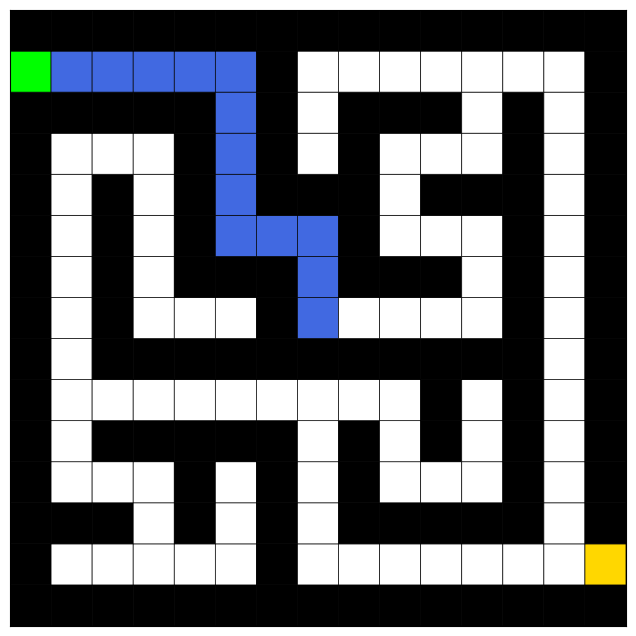

In [606]:
def display_maze_with_path(maze, individual, start, end):
  """
  Muestra el laberinto y opcionalmente superpone un camino de solución.

  Args:
      maze (np.array): El array 2D NumPy para el laberinto (0=camino, 1=muro).
      individual (list, optional): Secuencia de movimientos (0,1,2,3) para el camino. Por defecto None.
      start (tuple, optional): Coordenadas de inicio (fila, col). Necesario si se provee individual. Por defecto None.
      end (tuple, optional): Coordenadas de fin (fila, col). Usado para marcar el punto final. Por defecto None.
      title_suffix (str, optional): Sufijo para añadir al título del gráfico.
  """
  cmap = ListedColormap(['white', 'black', 'royalblue', 'lime', 'gold'])
  maze_display = maze.copy().astype(float) # Usar float permite marcadores no enteros si fuera necesario

  path_coords = []

  if individual is not None and start is not None:
    rows, cols = maze.shape
    current_row, current_col = start
    if not (0 <= start[0] < rows and 0 <= start[1] < cols and maze[start[0], start[1]] == 0):
         print(f"Advertencia: El punto de inicio {start} no es válido en el laberinto.")
    else:
        path_coords.append(start)

    moves = {
        0: (1, 0),  # Abajo
        1: (-1, 0), # Arriba
        2: (0, -1), # Izquierda
        3: (0, 1)   # Derecha
    }

    for move_gene in individual:
        dr, dc = moves.get(move_gene, (0, 0))
        next_row, next_col = current_row + dr, current_col + dc

        if not (0 <= next_row < rows and 0 <= next_col < cols) or maze[next_row, next_col] == 1:
            print("[!] ILEGAL MOVEMENT: in block or outside of the maze")
            break
            # return

        current_row, current_col = next_row, next_col
        path_coords.append((current_row, current_col))

        if end is not None and (current_row, current_col) == end:
            print("[!] ILEGAL MOVEMENT: end reached")
            break
            #return

  path_cells_to_mark = [p for p in path_coords if p != start and p != end]
  for r, c in path_cells_to_mark:
      maze_display[r, c] = 2 # 2 representa el camino de la solución (azul)

  # Marcar el inicio con el valor 3 (verde lima)
  if start is not None and 0 <= start[0] < rows and 0 <= start[1] < cols:
      maze_display[start[0], start[1]] = 3

  # Marcar el fin con el valor 4 (rojo)
  if end is not None and 0 <= end[0] < rows and 0 <= end[1] < cols:
      maze_display[end[0], end[1]] = 4

  plt.figure(figsize=(8, 8))
  norm = plt.cm.colors.BoundaryNorm(np.arange(-0.5, 5.5, 1), cmap.N)
  plt.pcolor(maze_display[::-1], cmap=cmap, edgecolors='k', linewidths=0.5, norm=norm)

  plt.gca().set_aspect('equal')
  plt.xticks([])
  plt.yticks([])
  plt.show()

print(best_solution)
display_maze_with_path(maze, pop[4], origin, goal)